In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent))
str(Path.cwd().parent)

'c:\\Users\\jaesc2\\GitHub\\skforecast'

In [2]:
################################################################################
#                            ForecasterAutoreg                                 #
#                                                                              #
# This work by Joaquin Amat Rodrigo and Javier Escobar Ortiz is licensed       #
# under a Creative Commons Attribution 4.0 International License.              #
################################################################################
# coding=utf-8

from typing import Union, Dict, List, Tuple, Any, Optional
import warnings
import logging
import sys
import numpy as np
import pandas as pd
from sklearn.base import clone
import pmdarima
from pmdarima.arima import ARIMA

import skforecast
from skforecast.utils import initialize_lags
from skforecast.utils import check_y
from skforecast.utils import check_exog
from skforecast.utils import preprocess_y
from skforecast.utils import preprocess_last_window
from skforecast.utils import preprocess_exog
from skforecast.utils import expand_index
from skforecast.utils import check_predict_input
from skforecast.utils import transform_series
from skforecast.utils import transform_dataframe

logging.basicConfig(
    format = '%(name)-10s %(levelname)-5s %(message)s', 
    level  = logging.INFO,
)

In [11]:
class ForecasterSarimax():
    """
    This class turns ARIMA model from pmdarima library into a Forecaster compatible with 
    the skforecast API.
    
    Parameters
    ----------
    regressor : pmdarima.arima.ARIMA
        An instance of an ARIMA from pmdarima library. This model internally wraps the
        statsmodels SARIMAX class.

    transformer_y : object transformer (preprocessor), default `None`
        An instance of a transformer (preprocessor) compatible with the scikit-learn
        preprocessing API with methods: fit, transform, fit_transform and inverse_transform.
        ColumnTransformers are not allowed since they do not have inverse_transform method.
        The transformation is applied to `y` before training the forecaster. 
        **New in version 0.5.0**

    transformer_exog : object transformer (preprocessor), default `None`
        An instance of a transformer (preprocessor) compatible with the scikit-learn
        preprocessing API. The transformation is applied to `exog` before training the
        forecaster. `inverse_transform` is not available when using ColumnTransformers.
    
    Attributes
    ----------
    regressor : pmdarima.arima.ARIMA
        An instance of an ARIMA from pmdarima library. The model internally wraps the
        statsmodels SARIMAX class

    params: dict
        Parameters of the sarimax model.
        
    transformer_y : object transformer (preprocessor), default `None`
        An instance of a transformer (preprocessor) compatible with the scikit-learn
        preprocessing API with methods: fit, transform, fit_transform and inverse_transform.
        ColumnTransformers are not allowed since they do not have inverse_transform method.
        The transformation is applied to `y` before training the forecaster.

    transformer_exog : object transformer (preprocessor), default `None`
        An instance of a transformer (preprocessor) compatible with the scikit-learn
        preprocessing API. The transformation is applied to `exog` before training the
        forecaster. `inverse_transform` is not available when using ColumnTransformers.
   
    window_size : int
        Size of the window needed to create the predictors. It is equal to
        max value of the parameters p,q,P,D of the ARIMA.

    last_window : pandas Series
        Last window the forecaster has seen during trained. It stores the
        values needed to predict the next `step` right after the training data.
        
    fitted : Bool
        Tag to identify if the regressor has been fitted (trained).
        
    index_type : type
        Type of index of the input used in training.
        
    index_freq : str
        Frequency of Index of the input used in training.
        
    training_range : pandas Index
        First and last values of index of the data used during training.
        
    included_exog : bool
        If the forecaster has been trained using exogenous variable/s.
        
    exog_type : type
        Type of exogenous variable/s used in training.
        
    exog_col_names : list
        Names of columns of `exog` if `exog` used in training was a pandas
        DataFrame.

    creation_date : str
        Date of creation.

    fit_date : str
        Date of last fit.

    skforcast_version : str
        Version of skforecast library used to create the forecaster.

    python_version : str
        Version of python used to create the forecaster.
        **New in version 0.5.0**
     
    """
    
    def __init__(
        self,
        regressor: ARIMA,
        transformer_y: Optional[object]=None,
        transformer_exog: Optional[object]=None,
    ) -> None:
        
        self.regressor               = regressor
        self.transformer_y           = transformer_y
        self.transformer_exog        = transformer_exog
        self.index_freq              = None
        self.training_range          = None
        self.last_window             = None
        self.included_exog           = False
        self.exog_type               = None
        self.exog_col_names          = None
        self.fitted                  = False
        self.creation_date           = pd.Timestamp.today().strftime('%Y-%m-%d %H:%M:%S')
        self.fit_date                = None
        self.skforcast_version       = skforecast.__version__
        self.python_version          = sys.version.split(" ")[0]
        self.index_type              = None
        
        if not isinstance(self.regressor, pmdarima.arima.ARIMA):
            raise ValueError(
                f"regressor must be an instance of type pmdarima.arima.ARIMA. "
                f"Got {type(regressor)}."
            )

        self.params = self.regressor.get_params(deep=True)
        self.window_size = max([
                            self.params['order'][0], self.params['order'][2],
                            self.params['seasonal_order'][0], self.params['seasonal_order'][2]
                           ])


    def __repr__(
        self
    ) -> str:
        """
        Information displayed when a ForecasterSarimax object is printed.
        """

        info = (
            f"{'=' * len(str(type(self)).split('.')[1])} \n"
            f"{str(type(self)).split('.')[1]} \n"
            f"{'=' * len(str(type(self)).split('.')[1])} \n"
            f"Regressor: {self.regressor} \n"
            f"Regressor parameters: {self.params} \n"
            f"Window size: {self.window_size} \n"
            f"Transformer for y: {self.transformer_y} \n"
            f"Transformer for exog: {self.transformer_exog} \n"
            f"Exogenous included: {self.included_exog} \n"
            f"Type of exogenous variable: {self.exog_type} \n"
            f"Exogenous variables names: {self.exog_col_names} \n"
            f"Training range: {self.training_range.to_list() if self.fitted else None} \n"
            f"Training index type: {str(self.index_type).split('.')[-1][:-2] if self.fitted else None} \n"
            f"Training index frequency: {self.index_freq if self.fitted else None} \n"
            f"Creation date: {self.creation_date} \n"
            f"Last fit date: {self.fit_date} \n"
            f"Skforecast version: {self.skforcast_version} \n"
            f"Python version: {self.python_version} \n"
        )

        return info

        
    def fit(
        self,
        y: pd.Series,
        exog: Optional[Union[pd.Series, pd.DataFrame]]=None
    ) -> None:
        """
        Training Forecaster.
        
        Parameters
        ----------        
        y : pandas Series
            Training time series.
            
        exog : pandas Series, pandas DataFrame, default `None`
            Exogenous variable/s included as predictor/s. Must have the same
            number of observations as `y` and their indexes must be aligned so
            that y[i] is regressed on exog[i].

        Returns 
        -------
        None
        
        """
        
        # Reset values in case the forecaster has already been fitted.
        self.index_type           = None
        self.index_freq           = None
        self.last_window          = None
        self.included_exog        = False
        self.exog_type            = None
        self.exog_col_names       = None
        self.X_train_col_names    = None
        self.in_sample_residuals  = None
        self.fitted               = False
        self.training_range       = None
        
        if exog is not None:
            self.included_exog = True
            self.exog_type = type(exog)
            self.exog_col_names = \
                 exog.columns.to_list() if isinstance(exog, pd.DataFrame) else exog.name

        y = transform_series(
                series            = y,
                transformer       = self.transformer_y,
                fit               = True,
                inverse_transform = False
            )

        if exog is not None:
            if isinstance(exog, pd.Series):
                exog = transform_series(
                            series            = exog,
                            transformer       = self.transformer_exog,
                            fit               = True,
                            inverse_transform = False
                       )
                # pmdarima.arima.ARIMA only accepts DataFrames or 2d-arrays as exog       
                exog = exog.to_frame(name=exog.name)
            else:
                exog = transform_dataframe(
                            df                = exog,
                            transformer       = self.transformer_exog,
                            fit               = True,
                            inverse_transform = False
                       )

        self.regressor.fit(y=y, X=exog)
        self.fitted = True
        self.fit_date = pd.Timestamp.today().strftime('%Y-%m-%d %H:%M:%S')
        self.training_range = y.index[[0, -1]]
        self.index_type = type(y.index)
        if isinstance(y.index, pd.DatetimeIndex):
            self.index_freq = y.index.freqstr
        else: 
            self.index_freq = y.index.step
        self.last_window = y.iloc[-self.window_size:].copy()
    
          
    def predict(
        self,
        steps: int,
        last_window: Optional[pd.Series]=None,
        last_window_exog: Optional[Union[pd.Series, pd.DataFrame]]=None,
        exog: Optional[Union[pd.Series, pd.DataFrame]]=None
    ) -> pd.Series:
        """
        Predict n steps ahead. It is a recursive process in which, each prediction,
        is used as a predictor for the next step.
        
        Parameters
        ----------
        steps : int
            Number of future steps predicted.
            
        last_window : pandas Series, default `None`
            Values of the series used to create the predictors needed in the 
            first iteration of prediction (t + 1). This is used when the predictions
            do not follow directly from the end of the training data.

        last_window_exog : pandas Series, pandas DataFrame, default `None`
            Values of the exogenous variables aligned with `last_window`. Only
            need when `last_window` is not None and the forecaster has been
            trained including exogenous variables. This is used when the predictions
            do not follow directly from the end of the training data.
            
        exog : pandas Series, pandas DataFrame, default `None`
            Value of the exogenous variable/s for the next steps.

        Returns 
        -------
        predictions : pandas Series
            Predicted values.
            
        """

        if exog is not None:
            if isinstance(exog, pd.DataFrame):
                exog = transform_dataframe(
                           df                = exog,
                           transformer       = self.transformer_exog,
                           fit               = False,
                           inverse_transform = False
                       )
            else:
                exog = transform_series(
                           series            = exog,
                           transformer       = self.transformer_exog,
                           fit               = False,
                           inverse_transform = False
                       )
                # pmdarima.arima.ARIMA only accepts DataFrames or 2d-arrays as exog
                exog = exog.to_frame(name=exog.name)
            
            exog_values = exog.iloc[:steps, ]
        else:
            exog_values = None


        if last_window is None:
        # Predictions follow directly from the end of the training data
            predictions = self.regressor.predict(
                          n_periods   = steps,
                          X           = exog_values
                      )
        else:
        # Predictions do not follow directly from the end of the training data. The
        # internal statsmodels SARIMAX model need to be updated using the apply method.
            last_window = transform_series(
                            series            = last_window,
                            transformer       = self.transformer_y,
                            fit               = False,
                            inverse_transform = False
                        )

            if last_window_exog is not None:
                if isinstance(last_window_exog, pd.DataFrame):
                    exog = transform_dataframe(
                            df                = last_window_exog,
                            transformer       = self.transformer_exog,
                            fit               = False,
                            inverse_transform = False
                        )
                else:
                    exog = transform_series(
                            series            = last_window_exog,
                            transformer       = self.transformer_exog,
                            fit               = False,
                            inverse_transform = False
                        )
                    exog = exog.to_frame(name=exog.name)

            if self.included_exog:
                self.regressor.arima_res_ = self.regressor.arima_res_.apply(
                                                endog = last_window,
                                                exog  = last_window_exog,
                                                refit  = False
                                            )
            else:
                self.regressor.arima_res_ = self.regressor.arima_res_.apply(
                                                endog = last_window,
                                                refit  = False
                                            )
            
            predictions = self.regressor.predict(
                            n_periods   = steps,
                            X           = exog_values
                        )

        # Reverse the transformation if needed
        predictions = transform_series(
                          series            = predictions,
                          transformer       = self.transformer_y,
                          fit               = False,
                          inverse_transform = True
                      )
        predictions.name = 'pred'

        return predictions
    
        
    def predict_interval(
        self,
        steps: int,
        last_window: Optional[pd.Series]=None,
        last_window_exog: Optional[pd.Series]=None,
        exog: Optional[Union[pd.Series, pd.DataFrame]]=None,
        alpha: float=0.05,
    ) -> pd.DataFrame:
        """
        Iterative process in which, each prediction, is used as a predictor
        for the next step. Both, predictions and intervals, are returned.
        
        Parameters
        ---------- 
        steps : int
            Number of future steps predicted.
            
        last_window : pandas Series, default `None`
            Values of the series used to create the predictors needed in the 
            first iteration of prediction (t + 1).

        last_window_exog : pandas Series, pandas DataFrame, default `None`
            Values of the exogenous variables aligned with `last_window`. Only
            need when `last_window` is not None and the forecaster has been
            trained including exogenous variables.
            
        exog : pandas Series, pandas DataFrame, default `None`
            Exogenous variable/s included as predictor/s.
            
        alpha : float, default=0.05
            The confidence intervals for the forecasts are (1 - alpha) %

        Returns 
        -------
        predictions : pandas DataFrame
            Values predicted by the forecaster and their estimated interval:

            - pred: predictions.
            - lower_bound: lower bound of the interval.
            - upper_bound: upper bound interval of the interval.

        """
        
        if exog is not None:
            if isinstance(exog, pd.DataFrame):
                exog = transform_dataframe(
                           df                = exog,
                           transformer       = self.transformer_exog,
                           fit               = False,
                           inverse_transform = False
                       )
            else:
                exog = transform_series(
                           series            = exog,
                           transformer       = self.transformer_exog,
                           fit               = False,
                           inverse_transform = False
                       )
                # pmdarima.arima.ARIMA only accepts DataFrames or 2d-arrays as exog
                exog = exog.to_frame(name=exog.name)
            
            exog_values = exog.iloc[:steps, ]
        else:
            exog_values = None


        if last_window is None:
            # Predictions follow directly from the end of the training data
            predicted_mean, conf_int = self.regressor.predict(
                                        n_periods       = steps,
                                        X               = exog_values,
                                        alpha           = alpha,
                                        return_conf_int = True
                                      )
        else:
            # Predictions do not follow directly from the end of the training data. The
            # internal statsmodels SARIMAX model need to be updated using the apply method.
            last_window = transform_series(
                            series            = last_window,
                            transformer       = self.transformer_y,
                            fit               = False,
                            inverse_transform = False
                        )

            if last_window_exog is not None:
                if isinstance(last_window_exog, pd.DataFrame):
                    exog = transform_dataframe(
                            df                = last_window_exog,
                            transformer       = self.transformer_exog,
                            fit               = False,
                            inverse_transform = False
                        )
                else:
                    exog = transform_series(
                            series            = last_window_exog,
                            transformer       = self.transformer_exog,
                            fit               = False,
                            inverse_transform = False
                        )
                    exog = exog.to_frame(name=exog.name)

            if self.included_exog:
                self.regressor.arima_res_ = self.regressor.arima_res_.apply(
                                                endog = last_window,
                                                exog  = last_window_exog,
                                                refit  = False
                                            )
            else:
                self.regressor.arima_res_ = self.regressor.arima_res_.apply(
                                                endog = last_window,
                                                refit  = False
                                            )

            predicted_mean, conf_int = self.regressor.predict(
                                            n_periods       = steps,
                                            X               = exog_values,
                                            alpha           = alpha,
                                            return_conf_int = True
                                    )

                                    
        predictions = predicted_mean.to_frame(name="pred")
        predictions['lower_bound'] = conf_int[:, 0]
        predictions['upper_bound'] = conf_int[:, 1]

        for col in predictions.columns:
            predictions[col] = transform_series(
                                    series            = predictions[col],
                                    transformer       = self.transformer_y,
                                    fit               = False,
                                    inverse_transform = True
                                )

        return predictions

    
    def set_params(
        self, 
        **params: dict
    ) -> None:
        """
        Set new values to the parameters of the model stored in the forecaster.
        
        Parameters
        ----------
        params : dict
            Parameters values.

        Returns 
        -------
        self
        
        """

        self.regressor = clone(self.regressor)
        self.regressor.set_params(**params)
        
    
    def get_feature_importance(
        self
    ) -> pd.DataFrame:
        """      
        Return feature importance of the regressor stored in the
        forecaster.

        Parameters
        ----------
        self

        Returns
        -------
        feature_importance : pandas DataFrame
            Feature importance associated with each predictor.

        """

        try:
            feature_importance = self.regressor.params().to_frame().reset_index()
            feature_importance.columns = ['feature', 'importance']
        except:   
            warnings.warn(
                f"Impossible to access feature importance for regressor of type {type(self.regressor)}."
            )
            feature_importance = None

        return feature_importance

In [3]:
from skforecast.ForecasterSarimax import ForecasterSarimax

In [27]:
# Data download
# ==============================================================================
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv'
data = pd.read_csv(url, sep=',')

# Data preparation
# ==============================================================================
data = data.rename(columns={'fecha': 'date'})
data['date'] = pd.to_datetime(data['date'], format='%Y/%m/%d')
data = data.set_index('date')
data = data.rename(columns={'x': 'y'})
data = data.asfreq('MS')
data = data.sort_index()
display(data.head())

# Split data into train-test
# ==============================================================================
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

,y,exog_1,exog_2
date,,,
1992-04-01,0.379808,0.958792,1.166029
1992-05-01,0.361801,0.951993,1.117859
1992-06-01,0.410534,0.952955,1.067942
1992-07-01,0.483389,0.958078,1.097376
1992-08-01,0.475463,0.956370,1.122199


Train dates : 1992-04-01 00:00:00 --- 2005-06-01 00:00:00  (n=159)
Test dates  : 2005-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=36)


In [7]:
# pmdarima SARIMAX
# =====================================================================================
forecaster = ForecasterSarimax(
                regressor = ARIMA(order=(1,1,5), seasonal_order=(0, 0, 0, 0), trend=None, with_intercept=False, maxiter=1000)
            )
forecaster


ForecasterSarimax 
Regressor:  ARIMA(1,1,5)(0,0,0)[0]           
Regressor parameters: {'maxiter': 1000, 'method': 'lbfgs', 'order': (1, 1, 5), 'out_of_sample_size': 0, 'scoring': 'mse', 'scoring_args': None, 'seasonal_order': (0, 0, 0, 0), 'start_params': None, 'suppress_warnings': False, 'trend': None, 'with_intercept': False} 
Window size: 5 
Transformer for y: None 
Transformer for exog: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Creation date: 2022-12-27 17:13:35 
Last fit date: None 
Skforecast version: 0.7.dev 
Python version: 3.9.13 

In [28]:
data_train['y'].tail()

date
2005-02-01    0.597639
2005-03-01    0.652590
2005-04-01    0.670505
2005-05-01    0.695248
2005-06-01    0.842263
Freq: MS, Name: y, dtype: float64

In [150]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

index = pd.period_range(start='2000', periods=3, freq='A')
original_observations = pd.Series([1.2, 1.5, 1.8], index=index)
original_exog = pd.Series([2, 2.7, 1.3], index=index)
mod = SARIMAX(endog=original_observations, exog=original_exog)
res = mod.fit()
# print(res.params)
# print(res.fittedvalues)
# print(res.predict(1))
print(res.forecast(1, exog=original_exog.iloc[-1,]))

2003    0.398534
Freq: A-DEC, dtype: float64


c:\Users\jaesc2\Miniconda3\envs\skforecast\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [151]:
new_index = pd.period_range(start='1980', periods=3, freq='A')
new_observations = pd.Series([1.4, 0.3, 1.2], index=new_index)
new_exog = pd.Series([6, 4.3, 3.1], index=new_index)
new_res = res.apply(new_observations, exog=new_exog, refit=False)
# print(new_res.params)
# print(new_res.fittedvalues)
# print(new_res.predict(1))
print(new_res.forecast(1, exog=original_exog.iloc[-1,]))

new_index = pd.period_range(start='1980', periods=3, freq='A')
new_observations = pd.Series([1.4, 0.3, 1.2], index=new_index)
new_exog = pd.Series([6, 4.3, 3.1], index=new_index)
new_res = res.apply(new_observations, exog=new_exog, refit=True)
# print(new_res.params)
# print(new_res.fittedvalues)
# print(new_res.predict(1))
print(new_res.forecast(1, exog=original_exog.iloc[-1,]))

1983    1.405683
Freq: A-DEC, dtype: float64
1983   -0.379792
Freq: A-DEC, dtype: float64


c:\Users\jaesc2\Miniconda3\envs\skforecast\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [156]:
# Try append
index = pd.period_range(start='2000', periods=3, freq='A')
original_observations = pd.Series([1.2, 1.5, 1.8], index=index)
original_exog = pd.Series([2, 2.7, 1.3], index=index)
mod = SARIMAX(endog=original_observations, exog=original_exog)
res = mod.fit()
print(res.forecast(1, exog=original_exog.iloc[-1,]))

new_index = pd.period_range(start='2003', periods=3, freq='A')
new_observations = pd.Series([1.4, 0.3, 1.2], index=new_index)
new_exog = pd.Series([6, 4.3, 3.1], index=new_index)
new_res = res.append(new_observations, exog=new_exog, refit=False)
print(new_res.forecast(1, exog=original_exog.iloc[-1,]))

new_index = pd.period_range(start='2003', periods=3, freq='A')
new_observations = pd.Series([1.4, 0.3, 1.2], index=new_index)
new_exog = pd.Series([6, 4.3, 3.1], index=new_index)
new_res = res.append(new_observations, exog=new_exog, refit=True)
print(new_res.forecast(1, exog=original_exog.iloc[-1,]))

2003    0.398534
Freq: A-DEC, dtype: float64
2006    1.405683
Freq: A-DEC, dtype: float64
2006    1.008943
Freq: A-DEC, dtype: float64


c:\Users\jaesc2\Miniconda3\envs\skforecast\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [119]:
new_index = pd.period_range(start='1980', periods=3, freq='A')
new_observations = pd.Series([1.4, 0.3, 1.2], index=new_index)
new_res = res.apply(new_observations, refit=True)
print(res.params)
print(res.fittedvalues)
print(res.predict(1))
print(res.forecast(1))

ar.L1     0.975611
sigma2    0.088896
dtype: float64
2000    0.000000
2001    1.170734
Freq: A-DEC, dtype: float64
2001    1.170734
Freq: A-DEC, dtype: float64
2002    1.463417
Freq: A-DEC, dtype: float64


In [112]:
new_index = pd.period_range(start='2000', periods=2, freq='A')
new_observations = pd.Series([1.2, 1.5], index=new_index)
new_res = res.apply(original_observations, refit=False)
print(new_res.params)
print(new_res.fittedvalues)
print(new_res.predict(1))
print(new_res.forecast(1))

ar.L1     0.975611
sigma2    0.088896
dtype: float64
2000    0.000000
2001    1.170734
Freq: A-DEC, dtype: float64
2001    1.170734
Freq: A-DEC, dtype: float64
2002    1.463417
Freq: A-DEC, dtype: float64


In [103]:
data_train['y'].tail()

date
2005-02-01    0.597639
2005-03-01    0.652590
2005-04-01    0.670505
2005-05-01    0.695248
2005-06-01    0.842263
Freq: MS, Name: y, dtype: float64

In [173]:
forecaster_1 = ForecasterSarimax(
                regressor = ARIMA(order=(5,2,3), seasonal_order=(0, 0, 0, 0), trend=None, with_intercept=False, maxiter=1000, suppress_warnings=True)
            )
forecaster_1.fit(y=data_train['y'])
pred_1 = forecaster_1.predict(steps=5)

lengths = list(range(11))
# lengths = list(range(25, 30))
preds_2 = [pred_1]

for n in lengths:
    forecaster_2 = ForecasterSarimax(
                    regressor = ARIMA(order=(5,2,3), seasonal_order=(0, 0, 0, 0), trend=None, with_intercept=False, maxiter=1000, suppress_warnings=True)
                )
    forecaster_2.fit(y=data_train['y'])
    pred_2 = forecaster_2.predict(steps=5, last_window=data_train['y'].iloc[-n:])
    # pred_2 = forecaster_2.predict(steps=5)
    pred_2.name = f'{n}'
    preds_2.append(pred_2)

pd.concat(preds_2, axis=1)

,pred,0,1,2,3,4,5,6,7,8,9,10
2005-07-01,0.902099,0.902099,1.263395,0.989278,0.930796,0.904541,0.899217,0.777660,0.769616,0.780467,0.786612,0.809672
2005-08-01,0.859980,0.859980,1.684526,1.136293,1.009392,0.957028,0.947791,0.713999,0.694996,0.710476,0.730579,0.767940
2005-09-01,0.840585,0.840585,2.105657,1.283308,1.092949,1.021208,1.008523,0.633072,0.609298,0.633794,0.662388,0.710521
2005-10-01,0.915556,0.915556,2.526789,1.430323,1.183857,1.091902,1.074543,0.620101,0.586613,0.617839,0.653522,0.723204
2005-11-01,0.845797,0.845797,2.947920,1.577338,1.270039,1.152433,1.131733,0.533093,0.491707,0.529287,0.578678,0.657608


In [161]:
# Try changing exog and with all series as last window
forecaster_1 = ForecasterSarimax(
                regressor = ARIMA(order=(5,2,3), seasonal_order=(0, 0, 0, 0), trend=None, with_intercept=False, maxiter=1000, suppress_warnings=True)
            )
forecaster_1.fit(y=data_train['y'], exog=data_train['exog_1'])
pred_1 = forecaster_1.predict(steps=5, exog=data_test['exog_1'])

lengths = list(range(5))
lengths = 0
# lengths = list(range(25, 30))
preds_2 = [pred_1]

for i, lw_exog in enumerate([data_train['y'], data_train['exog_1']]):
    forecaster_2 = ForecasterSarimax(
                    regressor = ARIMA(order=(5,2,3), seasonal_order=(0, 0, 0, 0), trend=None, with_intercept=False, maxiter=1000, suppress_warnings=True)
                )
    forecaster_2.fit(y=data_train['y'], exog=data_train['exog_1'])
    pred_2 = forecaster_2.predict(steps=5, exog=data_test['exog_1'], last_window=data_train['y'], last_window_exog=lw_exog)
    # pred_2 = forecaster_2.predict(steps=5)
    pred_2.name = f'{i}'
    preds_2.append(pred_2)

pd.concat(preds_2, axis=1)

,pred,0,1
2005-07-01,0.834083,1.583247,0.834083
2005-08-01,0.775471,1.570892,0.775471
2005-09-01,0.763014,1.549400,0.763014
2005-10-01,0.738576,1.517228,0.738576
2005-11-01,0.700156,1.524830,0.700156


In [169]:
forecaster_1.regressor.predict(n_periods=36, X=data_test['exog_1'].to_frame())

2005-07-01    0.834083
2005-08-01    0.775471
2005-09-01    0.763014
2005-10-01    0.738576
2005-11-01    0.700156
2005-12-01    0.803202
2006-01-01    0.877273
2006-02-01    0.840496
2006-03-01    0.868976
2006-04-01    0.834666
2006-05-01    0.805690
2006-06-01    0.804989
2006-07-01    0.764330
2006-08-01    0.753788
2006-09-01    0.757883
2006-10-01    0.742118
2006-11-01    0.718698
2006-12-01    0.809200
2007-01-01    0.857758
2007-02-01    0.850377
2007-03-01    0.853802
2007-04-01    0.803226
2007-05-01    0.787759
2007-06-01    0.772675
2007-07-01    0.747909
2007-08-01    0.742488
2007-09-01    0.751111
2007-10-01    0.731793
2007-11-01    0.732950
2007-12-01    0.812696
2008-01-01    0.864117
2008-02-01    0.900863
2008-03-01    0.888723
2008-04-01    0.874010
2008-05-01    0.867312
2008-06-01    0.823210
Freq: MS, dtype: float64

In [170]:
forecaster_1.regressor.df_model()

10

In [171]:
forecaster_1.regressor.df_resid()

inf

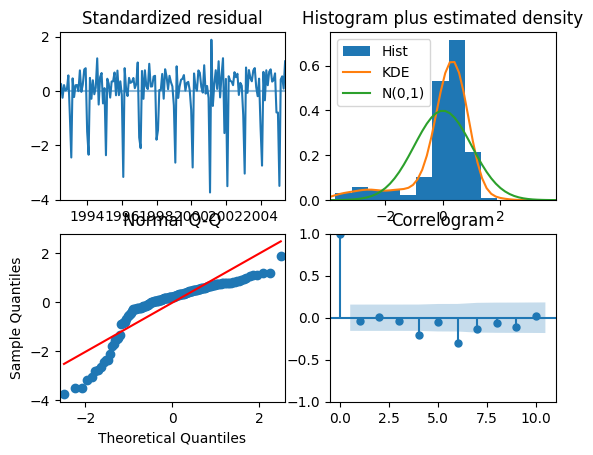

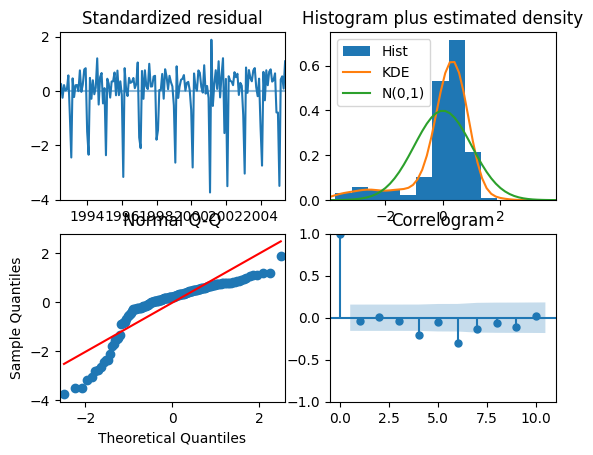

In [172]:
forecaster_1.regressor.plot_diagnostics()

In [127]:
forecaster_1.regressor.arima_res_.fittedvalues

date
1992-04-01    0.000000
1992-05-01    0.371971
1992-06-01    0.355788
1992-07-01    0.402180
1992-08-01    0.464897
                ...   
2005-02-01    1.146735
2005-03-01    0.632435
2005-04-01    0.706293
2005-05-01    0.669381
2005-06-01    0.764826
Freq: MS, Length: 159, dtype: float64

In [128]:
forecaster_2.regressor.arima_res_.fittedvalues

date
2004-10-01    0.000000
2004-11-01    1.156641
2004-12-01    1.190377
2005-01-01    1.228937
2005-02-01    1.151603
2005-03-01    0.632435
2005-04-01    0.706293
2005-05-01    0.669381
2005-06-01    0.764826
Freq: MS, dtype: float64

In [94]:
# Params
print(forecaster_1.regressor.arima_res_.params)
print(forecaster_2.regressor.arima_res_.params)
print('')

# Array containing autoregressive lag polynomial coefficients, ordered from lowest degree to highest. 
# Initialized with ones, unless a coefficient is constrained to be zero (in which case it is zero).
print(forecaster_1.regressor.arima_res_.polynomial_ar)
print(forecaster_2.regressor.arima_res_.polynomial_ar)
print('')

# Array containing moving average lag polynomial coefficients, ordered from lowest degree to highest. 
# Initialized with ones, unless a coefficient is constrained to be zero (in which case it is zero).print(forecaster_1.regressor.arima_res_.polynomial_ar)
print(forecaster_1.regressor.arima_res_.polynomial_ma)
print(forecaster_2.regressor.arima_res_.polynomial_ma)

ar.L1    -0.278167
ar.L2     0.208110
ar.L3     0.905169
ar.L4     0.149358
ar.L5    -0.038833
ma.L1     1.292218
ma.L2     0.998973
sigma2    0.018479
dtype: float64
ar.L1    -0.278167
ar.L2     0.208110
ar.L3     0.905169
ar.L4     0.149358
ar.L5    -0.038833
ma.L1     1.292218
ma.L2     0.998973
sigma2    0.018479
dtype: float64

[ 1.          0.2781674  -0.2081097  -0.9051687  -0.14935803  0.03883274]
[ 1.          0.2781674  -0.2081097  -0.9051687  -0.14935803  0.03883274]

[1.         1.29221759 0.99897309]
[1.         1.29221759 0.99897309]


In [44]:
data_train['y'].iloc[-1:]

date
2005-06-01    0.842263
Freq: MS, Name: y, dtype: float64

In [47]:
forecaster_2.regressor.arima_res_.polynomial_ma

array([ 1.        , -1.29225707,  0.48184762,  0.48315573, -1.29717801,
        0.98581836])

In [42]:
# Array containing seasonal autoregressive lag polynomial coefficients, ordered from lowest degree to highest. 
# Initialized with ones, unless a coefficient is constrained to be zero (in which case it is zero).
print(forecaster_1.regressor.arima_res_.polynomial_seasonal_ar)
print(forecaster_2.regressor.arima_res_.polynomial_seasonal_ar)
print('')

# Array containing seasonal moving average lag polynomial coefficients, ordered from lowest degree to highest.
# Initialized with ones, unless a coefficient is constrained to be zero (in which case it is zero).
print(forecaster_1.regressor.arima_res_.polynomial_seasonal_ma)
print(forecaster_2.regressor.arima_res_.polynomial_seasonal_ma)

[1.]
[1.]

[1.]
[1.]


In [43]:
# Array containing trend polynomial coefficients, ordered from lowest degree to highest. 
# Initialized with ones, unless a coefficient is constrained to be zero (in which case it is zero).
print(forecaster_1.regressor.arima_res_.polynomial_trend)
print(forecaster_2.regressor.arima_res_.polynomial_trend)
print('')

# The orders of each of the polynomials in the model.
print(forecaster_1.regressor.arima_res_.model_orders)
print(forecaster_2.regressor.arima_res_.model_orders)
print('')

# List of parameters actually included in the model, in sorted order.
print(forecaster_1.regressor.arima_res_.param_terms)
print(forecaster_2.regressor.arima_res_.param_terms)

[]
[]

{'trend': 0, 'exog': 0, 'ar': 5, 'ma': 5, 'seasonal_ar': 0, 'seasonal_ma': 0, 'reduced_ar': 5, 'reduced_ma': 5, 'exog_variance': 0, 'measurement_variance': 0, 'variance': 1}
{'trend': 0, 'exog': 0, 'ar': 5, 'ma': 5, 'seasonal_ar': 0, 'seasonal_ma': 0, 'reduced_ar': 5, 'reduced_ma': 5, 'exog_variance': 0, 'measurement_variance': 0, 'variance': 1}

['ar', 'ma', 'variance']
['ar', 'ma', 'variance']


In [26]:
data_train['y'].iloc[-6:]

date
2005-01-01    1.170690
2005-02-01    0.597639
2005-03-01    0.652590
2005-04-01    0.670505
2005-05-01    0.695248
2005-06-01    0.842263
Freq: MS, Name: y, dtype: float64

In [30]:
data_train['exog_1'].iloc[-5:]

date
2005-02-01    1.520544
2005-03-01    1.506290
2005-04-01    1.487660
2005-05-01    1.457025
2005-06-01    1.441765
Freq: MS, Name: exog_1, dtype: float64

In [124]:
forecaster = ForecasterSarimax(
                regressor = ARIMA(order=(5,0,0), seasonal_order=(0, 0, 0, 0), trend=None, with_intercept=False, maxiter=1000, suppress_warnings=True)
            )
forecaster.fit(y=data_train['y'], exog=data_train['exog_1'])
forecaster.predict(steps=5, exog=data_test['exog_1'])

2005-07-01    0.955160
2005-08-01    0.999309
2005-09-01    1.006797
2005-10-01    0.966844
2005-11-01    0.899705
Freq: MS, Name: pred, dtype: float64

In [ ]:
forecaster.regressor.arima_res_.apply(
    endog = last_window,
    exog  = last_window_exog,
    refit = False
)

In [125]:
forecaster.regressor.arima_res_.fittedvalues

date
1992-04-01    0.586089
1992-05-01    0.448589
1992-06-01    0.453344
1992-07-01    0.509825
1992-08-01    0.580687
                ...   
2005-02-01    0.959333
2005-03-01    0.585896
2005-04-01    0.648927
2005-05-01    0.655163
2005-06-01    0.782031
Freq: MS, Length: 159, dtype: float64

In [29]:
forecaster.predict(
    steps=5,
    exog=data_test['exog_1'],
    last_window=data_train['y'].iloc[-5:],
    last_window_exog=data_train['exog_1'].iloc[-5:]
)

2005-07-01    0.757604
2005-08-01    0.684084
2005-09-01    0.618403
2005-10-01    0.560564
2005-11-01    0.571627
Freq: MS, Name: pred, dtype: float64

In [32]:
forecaster.predict(
    steps=5,
    exog=data_test['exog_1'],
    last_window=data_train['y'].iloc[-5:],
    last_window_exog=data_train['y'].iloc[-5:]
)

2005-07-01    1.348155
2005-08-01    1.327842
2005-09-01    1.312205
2005-10-01    1.287929
2005-11-01    1.287166
Freq: MS, Name: pred, dtype: float64

In [11]:
forecaster.predict_interval(steps=5, exog=data_test['exog_1'])

,pred,lower_bound,upper_bound
2005-07-01,0.932642,0.696401,1.168883
2005-08-01,1.010520,0.740315,1.280726
2005-09-01,1.033868,0.761807,1.305928
2005-10-01,0.988795,0.712712,1.264877
2005-11-01,0.945110,0.652227,1.237994


In [12]:
forecaster.predict_interval(
    steps=5,
    exog=data_test['exog_1'],
    last_window=data_train['y'].iloc[-6:],
    last_window_exog=data_train['exog_1'].iloc[-6:]
)

,pred,lower_bound,upper_bound
2005-07-01,0.804699,0.533423,1.075975
2005-08-01,0.795028,0.446933,1.143122
2005-09-01,0.780490,0.408405,1.152576
2005-10-01,0.742509,0.374417,1.110601
2005-11-01,0.735371,0.378384,1.092358
